## Course Project: Hateful Memes Detector

For the course project, we propose the use of CLIP (Contrastive Language–Image Pre-training) which is OpenAI’s latest mutimodal model to better understand multimodal hate speech involving images and text. We also compare it’s benchmark results to other state-of-the-art models presented by Facebook AI community.

#### **1.1 Data Loading and Setup**

For this project we are using the Hateful Memes dataset that contains 10,000+ new multimodal examples created by Facebook AI. Here we create the data paths for the training data, validation data and the test data.

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/My Drive/CS7643 Class Project/data'

Mounted at /content/drive
/content/drive/My Drive/CS7643 Class Project/data


In [3]:
import torch,json, os
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data_dir = '/kaggle/input/facebook-hateful-meme-dataset/data/'
data_dir="/content/drive/My Drive/CS7643 Class Project/data/"

# img_path = data_dir + "data_dir"
imag_path = data_dir + "img"
train_path = data_dir + "train.jsonl"
dev_path = data_dir + "dev.jsonl"
test_path = data_dir + "test.jsonl"

In [5]:
import os
os.listdir()

['dev.jsonl',
 'train.jsonl',
 'test.jsonl',
 'README.md',
 'LICENSE.txt',
 'img',
 'model-outputs',
 'YOURPATH',
 'final_predictions.pdf',
 'best_model.pt',
 'last_model.pt',
 'cosine_similarity.pdf']

#### **1.2 Defining the Data Loader**

We define the dataloader for our dataset as follows and also find the number of samples in each of training, validation and test datasets. We find that the training data consists of 8500 samples, the validation data consists of 500 samples and the test data consists of 1000 samples.

In [6]:
import torch,json, os
from PIL import Image

class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        text = self.data[index]["text"]
        label = self.data[index]["label"]
        
        return image, text, label

    def load_image_only(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        return image
    
    def get_label(self, index: int):
        label = self.data[index]["label"]
        return label
    
    def get_test_item(self, index: int):
        # Load images on the fly.
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        text = self.data[index]["text"]
        
        return image, text
    
    
    def __len__(self):
        return len(self.data)
train_data = HatefulMemesDataset(train_path)
val_data = HatefulMemesDataset(dev_path)
test_data = HatefulMemesDataset(test_path)

print('Data size of training data: %d samples' % len(train_data))
print('Data size of validation data: %d samples' % len(val_data))
print('Data size of test data: %d samples' % len(test_data))

Data size of training data: 8500 samples
Data size of validation data: 500 samples
Data size of test data: 1000 samples


In [7]:
# # ###Create a true label for train and testing data
train_label=[val[2] for val in train_data]
val_label=[val[2] for val in val_data]

#### **1.3 Testing the data loader**
Here we print one element from the validation dataset, the image, the text and the label to test the working of our dataloader.

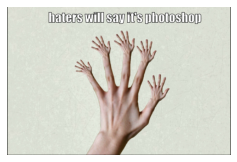

haters will say it's photoshop
0


In [16]:
import matplotlib.pyplot as plt
sample_memeID = 300
img, text, label = val_data[sample_memeID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
print(text)
print(label)

#### **1.4 Visualizing a group of samples**
Here we explore below some of the images in the dataset that are`Hateful`.

There are 250 hateful memes among 500
There are 250 hateful memes among 500


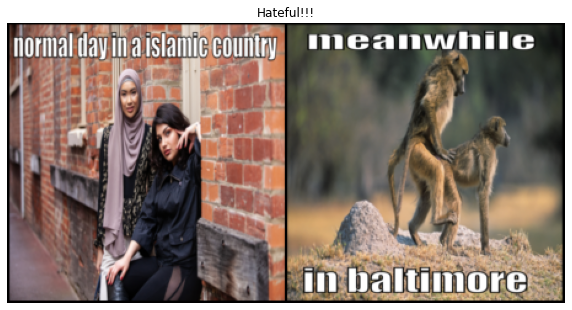

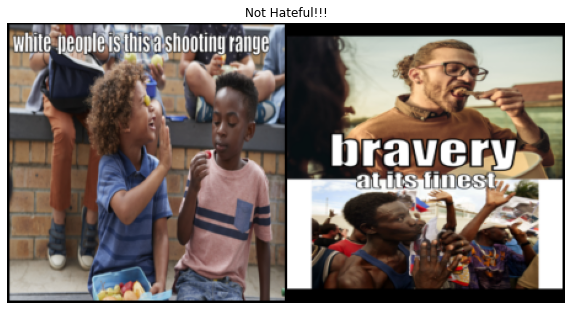

In [17]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

def show_image_group(dataset, image_ids, n_images,id_label):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow =2)
    plt.figure(figsize=(10,15)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid))
    if id_label==1:
      plt.title("Not Hateful!!!")
    else:
      plt.title("Hateful!!!")

hateful_ids = [id for id in range(0, len(val_data)) 
             if val_data.get_label(id)==0]
print('There are %d hateful memes among %d' % (len(hateful_ids), len(val_data)))
show_image_group(val_data, hateful_ids, 2,0)    

hateful_ids = [id for id in range(0, len(val_data)) 
             if val_data.get_label(id)==1]
print('There are %d hateful memes among %d' % (len(hateful_ids), len(val_data)))
show_image_group(val_data, hateful_ids, 2,1)

#### **2. Calculate cosine similarity between the images and text of memes**
In order to classify a meme to be hateful we need to  first find the association of the text features to the image features. Even if the text or the image may be unimodally hateful but combined they may not be hateful if the text is not associated with the image. With a powerful multimodal model like CLIP we can calculate the similarity between the different modalities and then fuse them early in the classification process. This approach enables the system to analyze the different modalities together, like people do.

#### **2.1 Loading CLIP**

In [8]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ln8nx3tr
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ln8nx3tr
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=d9a8885b72f277148bcd4eae25aa11b7363fbaedf9f8b335148b32ac4eda4f42
  Stored in directory: /tmp/pip-ephem-wheel-cache-blhkvpiu/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [9]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.13.0+cu116


`clip.available_models()` will list the names of available CLIP models.

In [10]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)
# model, preprocess = clip.load("RN50x4", device)
# model, preprocess = clip.load("RN50x64", device)
# model, preprocess = clip.load("RN50", device)
# model, preprocess = clip.load("ViT-L/14@336px", device)

model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 65.2MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [14]:
# model.config
# %ls
for p in model.parameters():
  p.requies_grad=False
  # print(p)

# num_image_embeds = 4
# num_labels = 1
# gradient_accumulation_steps = 20
# data_dir = './dataset'
# max_seq_length = 80 
# max_grad_norm = 0.5
# train_batch_size = 16
# eval_batch_size = 16
# image_encoder_size = 288
# image_features_size = 640
# num_train_epochs = 5

In [15]:
from torch.utils.data import DataLoader

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

#### **2.2 Ploting the Cosine Similarity Matrix**
We are going to feed 8 example images and their text to the model, and compare the similarity between the corresponding features.

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [16]:
original_images = []
images = []
texts = []
labels = []

# for i in range(0,len(val_data)):
for i in range(0,8):
    image, text, label  = val_data[i]
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(text)
    labels.append(label)
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize([desc for desc in texts]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T  ##cosine similarity

In [17]:
len(similarity),len(labels)

(8, 8)

In [18]:
import numpy as np
type(similarity),type(labels)
benigh=[similarity[i] for i,val in enumerate(labels) if val==0]
hate=[similarity[i] for i,val in enumerate(labels) if val==1]
# np.min(benigh),np.min(hate),np.max(benigh),np.max(hate),np.std(benigh),np.std(hate),len(benigh),len(hate)

In [19]:
val_data[2],val_data[5]

((<PIL.Image.Image image mode=RGB size=825x775 at 0x7FC6ABD7F940>,
  'your order comes to $37.50 and your white privilege discount brings the total to $37.50',
  1),
 (<PIL.Image.Image image mode=RGB size=531x799 at 0x7FC6ABD1BEE0>,
  "knowing white people , that's probably the baby father",
  1))

e 1


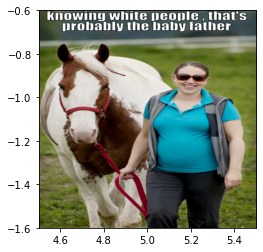

In [20]:
###the 6th images and 6th comments in image data
for i, image in enumerate(original_images):
    if i==5:
      plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6))
print(text[5],labels[5])
# print(texts[5]),similarity[5]

your order comes to $37.50 and your white privilege discount brings the total to $37.50 
 1


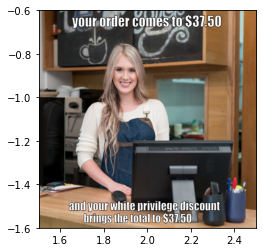

In [21]:
for i, image in enumerate(original_images):
    if i==2:
      plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6))
print(texts[2],'\n',labels[2])

In [12]:
#Create text labels that act as classes for our dataset
descriptions = {
      'good meme': 'a nonhateful meme that is good',
      'hateful meme': 'a hateful meme containing racism, sexism, nationality, religion or disability'
}

text_labels = [descriptions['good meme'],descriptions['hateful meme']]
text_tokens = clip.tokenize([desc for desc in text_labels]).to(device)

with torch.no_grad():
    F_text_features = model.encode_text(text_tokens).float()
    
F_text_features /= F_text_features.norm(dim=-1, keepdim=True) 
hate_similarity = (image_features.cpu() @ F_text_features.cpu().T).softmax(dim=-1)

In [23]:
hate_similarity_text = (text_features.cpu() @ F_text_features.cpu().T).softmax(dim=-1)

In [24]:
hate_similarity[2],hate_similarity_text[2]

(tensor([0.4961, 0.5039]), tensor([0.4991, 0.5009]))

In [25]:
hate_similarity[5],hate_similarity_text[5]

(tensor([0.5021, 0.4979]), tensor([0.5001, 0.4999]))

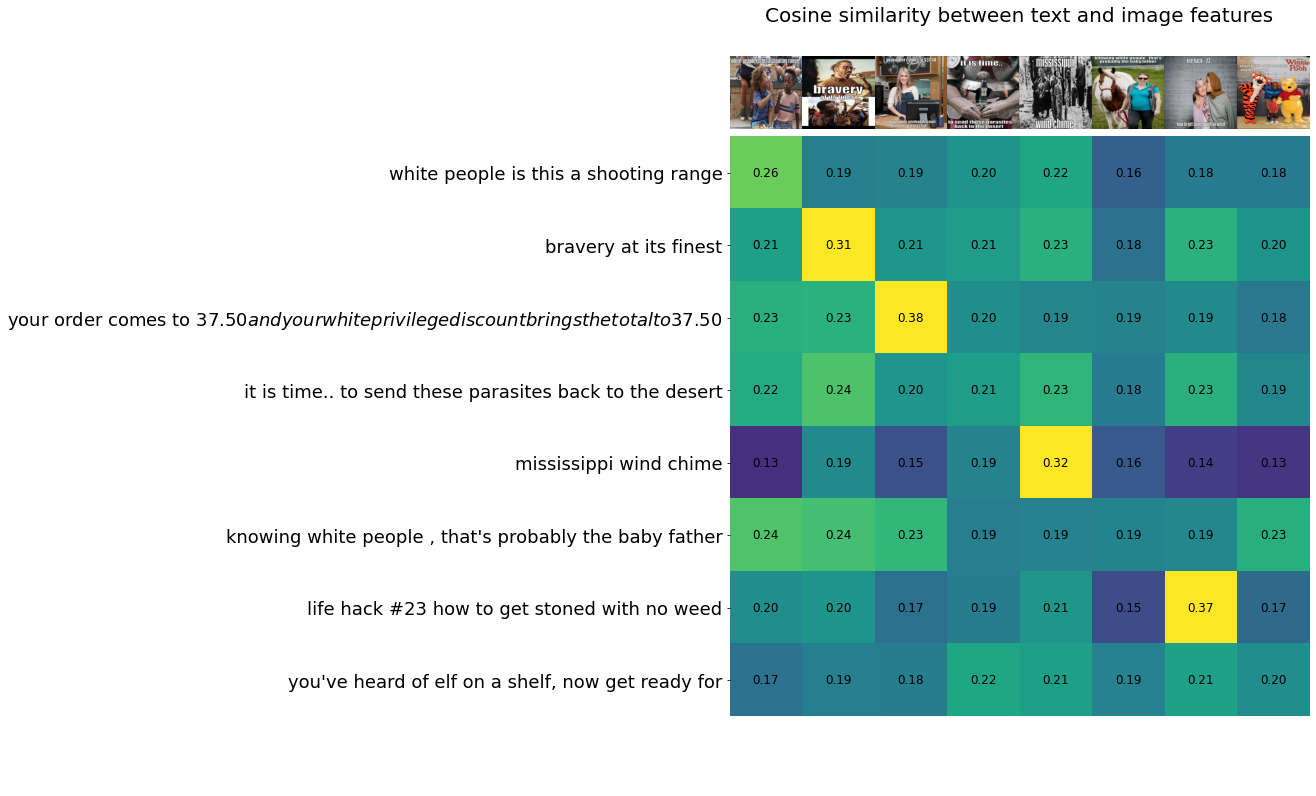

In [26]:
count = 8

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.savefig("cosine_similarity.pdf", bbox_inches = 'tight')

In [27]:
hate_similarity = (image_features.cpu() @ F_text_features.cpu().T).softmax(dim=-1)
hate_similarity

tensor([[0.5004, 0.4996],
        [0.4932, 0.5068],
        [0.4961, 0.5039],
        [0.4972, 0.5028],
        [0.5029, 0.4971],
        [0.5021, 0.4979],
        [0.4992, 0.5008],
        [0.5047, 0.4953]])

In [28]:
val_label[:8]

[1, 1, 1, 1, 1, 1, 1, 1]

#### 3. Zero shot image classification
A powerful model like CLIP is capable to make zero-shot predictions without any training or fine-tuning. Here we create text descriptions for a good meme and a hateful meme that act as classes for our dataset. 

In [29]:
#Create text labels that act as classes for our dataset
descriptions = {
      'good meme': 'a nonhateful meme that is good',
      'hateful meme': 'a hateful meme containing racism, sexism, nationality, religion or disability'
}

text_labels = [descriptions['good meme'],descriptions['hateful meme']]
text_tokens = clip.tokenize([desc for desc in text_labels]).to(device)

with torch.no_grad():
    F_text_features = model.encode_text(text_tokens).float()
    
F_text_features /= F_text_features.norm(dim=-1, keepdim=True) 

In [30]:
F_text_features

tensor([[ 0.0086, -0.0072,  0.0084,  ..., -0.0456,  0.0020, -0.0076],
        [ 0.0114, -0.0049,  0.0247,  ..., -0.0344,  0.0107, -0.0316]],
       device='cuda:0')

#### 3.1 Classifying the meme as Hateful or Non-hateful
We set the threshold for cosine similarity between the image and its text to be 0.2. This means that, if the cosine similarity between the image and its text falls below 0.2, we directly classify it as non-hateful. This is because, even if the model pairs the image to the hateful description, the text features does not relate in context to the hateful features of the image and thus combined cannot be hateful. 

If the cosine similarity between the image and its text is greater than 0.2, then we classify it based on whether the model associates the image to the`good meme`  or `hateful meme` description. This approach allows us to combine both the contributions of text and image features towards detecting hatefulness.

In [31]:
len(train_data),len(val_data),len(test_data)
# (8500, 500, 1000)

(8500, 500, 1000)

####Sensitivity Analysis
#####Assumption 1: When similarity<threshold then 'good meme'
#####Assumption 2: When similarity>threshold then 'good meme'

In [32]:
###Assumption 2
def clip_pred(indata,model_name,similarity_threshold):
  model, preprocess = clip.load(model_name, device)
  descriptions = {
      'good meme': 'a nonhateful meme that is good',
      'hateful meme': 'a hateful meme containing racism, sexism, nationality, religion or disability'
  }
  text_labels = [descriptions['good meme'],descriptions['hateful meme']]
  text_tokens = clip.tokenize([desc for desc in text_labels]).to(device)

  with torch.no_grad():
      F_text_features = model.encode_text(text_tokens).float()
      
  F_text_features /= F_text_features.norm(dim=-1, keepdim=True) 

  ground_truth = []
  predicted = []
  # for i in range(len(train_data)):
  for i in range(len(indata)):
      # image, text, label  = train_data[i]
      image, text, label  = indata[i]
      ground_truth.append(label)
      image_input = preprocess(image).unsqueeze(0).to(device)
      text_input = clip.tokenize(text,truncate=True).to(device)
      
      with torch.no_grad():
          image_features = model.encode_image(image_input).float()
          text_features = model.encode_text(text_input).float()
          
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)
      similarity = image_features.cpu().numpy() @ text_features.cpu().numpy().T
      
      # if similarity >0.2:
      if similarity>similarity_threshold:
          predicted_label = 0
          predicted.append(predicted_label)
      else:
          hate_similarity = (image_features.cpu() @ F_text_features.cpu().T).softmax(dim=-1)
          if hate_similarity[0][0] > hate_similarity[0][1]:
              predicted_label = 0
              predicted.append(predicted_label)
          else:
              predicted_label = 1
              predicted.append(predicted_label)
  return(predicted)

In [33]:
def cal_accuracy(df_train_pred,df_val_pred,train_labe,val_label):
  #Calculate accuracy
  total_predictions = np.array(df_train_pred)
  total_ground_truth =  np.array(train_label)
  train_accuracy = np.mean((total_predictions == total_ground_truth).astype(float)) * 100
  print('The train accuracy of the model is %.2f' % (train_accuracy)+'%')

  #Calculate accuracy
  total_predictions = np.array(df_val_pred)
  total_ground_truth =  np.array(val_label)
  val_accuracy = np.mean((total_predictions == total_ground_truth).astype(float)) * 100
  print('The validation accuracy of the model is %.2f' % (val_accuracy)+'%')

  ##Calculate f1 score 
  from sklearn.metrics import f1_score
  train_f1,val_f1=f1_score(train_label, df_train_pred)*100,f1_score(val_label, df_val_pred)*100
  print('The train f1 score of the model is %.2f' % (f1_score(train_label, df_train_pred)*100)+'%')
  print('The validation f1 score of the model is %.2f' % (f1_score(val_label, df_val_pred)*100)+'%')
  return(train_accuracy,val_accuracy,train_f1,val_f1)

In [34]:
# ViT-B/32, RN50x16
import clip
import time
metrics_ge_thresh=pd.DataFrame(columns=['model','threshold','train_accuracy','val_accuracy','train_f1','val_f1'])
# threshold=0.2
# for model in clip.available_models():
for model in ['ViT-B/32','RN50x16']:
  for thresh in [0.05,0.1, 0.2, 0.4,0.5,0.6]:
    print(model,":","\n")
    threshold_new=thresh
    print(threshold_new,":","\n")
    begin_time=time.time()
    train_pred=clip_pred(train_data,model,threshold_new)
    val_pred=clip_pred(val_data,model,threshold_new)
    cal=pd.DataFrame(columns=['model','train_accuracy','val_accuracy','train_f1','val_f1'])
    train_accuracy,val_accuracy,train_f1,val_f1=cal_accuracy(train_pred,val_pred,train_label, val_label)
    # train_accuracy,val_accuracy,train_f1,val_f1=0,0,0,0
    cal=pd.DataFrame(columns=['model','threshold','train_accuracy','val_accuracy','train_f1','val_f1'])
    cal.loc[0,'model']=model
    cal.loc[0,'threshold']=threshold_new
    cal.loc[0,'train_accuracy']=train_accuracy
    cal.loc[0,'val_accuracy']=val_accuracy
    cal.loc[0,'train_f1']=train_f1
    cal.loc[0,'val_f1']=val_f1
    metrics_ge_thresh=pd.concat([metrics_ge_thresh,cal])
    end_time=time.time()
    print(end_time-begin_time,"\n")
metrics_ge_thresh=metrics_ge_thresh.reset_index(drop=True)
metrics_ge_thresh

ViT-B/32 : 

0.05 : 

The train accuracy of the model is 64.12%
The validation accuracy of the model is 50.00%
The train f1 score of the model is 0.00%
The validation f1 score of the model is 0.00%
375.88959097862244 

ViT-B/32 : 

0.1 : 

The train accuracy of the model is 64.12%
The validation accuracy of the model is 50.00%
The train f1 score of the model is 0.00%
The validation f1 score of the model is 0.00%
381.4847457408905 

ViT-B/32 : 

0.2 : 

The train accuracy of the model is 63.73%
The validation accuracy of the model is 50.60%
The train f1 score of the model is 4.58%
The validation f1 score of the model is 3.89%
380.9976644515991 

ViT-B/32 : 

0.4 : 

The train accuracy of the model is 61.36%
The validation accuracy of the model is 58.40%
The train f1 score of the model is 42.83%
The validation f1 score of the model is 51.40%
383.75081419944763 

ViT-B/32 : 

0.5 : 

The train accuracy of the model is 61.35%
The validation accuracy of the model is 58.40%
The train f1 scor

100%|████████████████████████████████████████| 630M/630M [00:06<00:00, 109MiB/s]


The train accuracy of the model is 64.12%
The validation accuracy of the model is 50.00%
The train f1 score of the model is 0.00%
The validation f1 score of the model is 0.00%
580.678854227066 

RN50x16 : 

0.1 : 

The train accuracy of the model is 64.12%
The validation accuracy of the model is 50.00%
The train f1 score of the model is 0.00%
The validation f1 score of the model is 0.00%
546.0235908031464 

RN50x16 : 

0.2 : 

The train accuracy of the model is 63.65%
The validation accuracy of the model is 51.60%
The train f1 score of the model is 5.96%
The validation f1 score of the model is 9.02%
548.2078266143799 

RN50x16 : 

0.4 : 

The train accuracy of the model is 56.66%
The validation accuracy of the model is 51.80%
The train f1 score of the model is 35.89%
The validation f1 score of the model is 44.08%
565.555216550827 

RN50x16 : 

0.5 : 

The train accuracy of the model is 57.07%
The validation accuracy of the model is 52.00%
The train f1 score of the model is 38.31%
The v

,model,threshold,train_accuracy,val_accuracy,train_f1,val_f1
0,ViT-B/32,0.05,64.117647,50.0,0.0,0.0
1,ViT-B/32,0.1,64.117647,50.0,0.0,0.0
2,ViT-B/32,0.2,63.729412,50.6,4.580625,3.891051
3,ViT-B/32,0.4,61.364706,58.4,42.827298,51.401869
4,ViT-B/32,0.5,61.352941,58.4,42.97865,51.401869
5,ViT-B/32,0.6,61.352941,58.4,42.97865,51.401869
6,RN50x16,0.05,64.117647,50.0,0.0,0.0
7,RN50x16,0.1,64.117647,50.0,0.0,0.0
8,RN50x16,0.2,63.647059,51.6,5.964699,9.022556
9,RN50x16,0.4,56.658824,51.8,35.885834,44.083527


####Assumption 1: similarity>threshold then 'good meme'

In [ ]:
def clip_pred_less(indata,model_name,similarity_threshold):
  model, preprocess = clip.load(model_name, device)
  descriptions = {
      'good meme': 'a nonhateful meme that is good',
      'hateful meme': 'a hateful meme containing racism, sexism, nationality, religion or disability'
  }
  text_labels = [descriptions['good meme'],descriptions['hateful meme']]
  text_tokens = clip.tokenize([desc for desc in text_labels]).to(device)

  with torch.no_grad():
      F_text_features = model.encode_text(text_tokens).float()
      
  F_text_features /= F_text_features.norm(dim=-1, keepdim=True) 

  ground_truth = []
  predicted = []
  # for i in range(len(train_data)):
  for i in range(len(indata)):
      # image, text, label  = train_data[i]
      image, text, label  = indata[i]
      ground_truth.append(label)
      image_input = preprocess(image).unsqueeze(0).to(device)
      text_input = clip.tokenize(text,truncate=True).to(device)
      
      with torch.no_grad():
          image_features = model.encode_image(image_input).float()
          text_features = model.encode_text(text_input).float()
          
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)
      similarity = image_features.cpu().numpy() @ text_features.cpu().numpy().T
      
      # if similarity >0.2:
      if similarity<similarity_threshold:
          predicted_label = 0
          predicted.append(predicted_label)
      else:
          hate_similarity = (image_features.cpu() @ F_text_features.cpu().T).softmax(dim=-1)
          if hate_similarity[0][0] > hate_similarity[0][1]:
              predicted_label = 0
              predicted.append(predicted_label)
          else:
              predicted_label = 1
              predicted.append(predicted_label)
  return(predicted)

In [ ]:
# ViT-B/32, RN50x16
import clip
import time
metrics=pd.DataFrame(columns=['model','threshold','train_accuracy','val_accuracy','train_f1','val_f1'])
# threshold=0.2
# for model in clip.available_models():
for model in ['ViT-B/32','RN50x16']:
  for thresh in [0.05,0.1, 0.2, 0.4,0.5,0.6]:
    print(model,":","\n")
    threshold_new=thresh
    print(threshold_new,":","\n")
    begin_time=time.time()
    train_pred=clip_pred_less(train_data,model,threshold_new)
    val_pred=clip_pred_less(val_data,model,threshold_new)
    cal=pd.DataFrame(columns=['model','train_accuracy','val_accuracy','train_f1','val_f1'])
    train_accuracy,val_accuracy,train_f1,val_f1=cal_accuracy(train_pred,val_pred,train_label, val_label)
    # train_accuracy,val_accuracy,train_f1,val_f1=0,0,0,0
    cal=pd.DataFrame(columns=['model','threshold','train_accuracy','val_accuracy','train_f1','val_f1'])
    cal.loc[0,'model']=model
    cal.loc[0,'threshold']=threshold_new
    cal.loc[0,'train_accuracy']=train_accuracy
    cal.loc[0,'val_accuracy']=val_accuracy
    cal.loc[0,'train_f1']=train_f1
    cal.loc[0,'val_f1']=val_f1
    metrics=pd.concat([metrics,cal])
    end_time=time.time()
    print(end_time-begin_time,"\n")
metrics=metrics.reset_index(drop=True)
metrics

ViT-B/32 : 

0.05 : 

The train accuracy of the model is 61.35%
The validation accuracy of the model is 58.40%
The train f1 score of the model is 42.98%
The validation f1 score of the model is 51.40%
368.6438126564026 

ViT-B/32 : 

0.1 : 

The train accuracy of the model is 61.35%
The validation accuracy of the model is 58.40%
The train f1 score of the model is 42.98%
The validation f1 score of the model is 51.40%
371.3579111099243 

ViT-B/32 : 

0.2 : 

The train accuracy of the model is 61.74%
The validation accuracy of the model is 57.80%
The train f1 score of the model is 41.72%
The validation f1 score of the model is 49.88%
372.707635641098 

ViT-B/32 : 

0.4 : 

The train accuracy of the model is 64.11%
The validation accuracy of the model is 50.00%
The train f1 score of the model is 0.52%
The validation f1 score of the model is 0.00%
372.2574496269226 

ViT-B/32 : 

0.5 : 

The train accuracy of the model is 64.12%
The validation accuracy of the model is 50.00%
The train f1 sco

,model,threshold,train_accuracy,val_accuracy,train_f1,val_f1
0,ViT-B/32,0.05,61.352941,58.4,42.97865,51.401869
1,ViT-B/32,0.1,61.352941,58.4,42.97865,51.401869
2,ViT-B/32,0.2,61.741176,57.8,41.72043,49.881235
3,ViT-B/32,0.4,64.105882,50.0,0.521682,0.0
4,ViT-B/32,0.5,64.117647,50.0,0.0,0.0
5,ViT-B/32,0.6,64.117647,50.0,0.0,0.0
6,RN50x16,0.05,57.070588,52.0,38.309383,44.700461
7,RN50x16,0.1,57.070588,52.0,38.309383,44.700461
8,RN50x16,0.2,57.541176,50.4,36.450079,40.669856
9,RN50x16,0.4,64.529412,50.2,6.337372,1.581028


#### 3.2 Calculating the accuracy and f1 score of 9 CLIP models
Final run for 9 CLIP Models with assumption: similarity less than 0.2 then good meme; ViT-B/16, RN101 and ViT-B/16 have accuracy above 55% which was surprising and remarkable given the model was not trained at all.

In [ ]:
import clip
import time
metrics=pd.DataFrame(columns=['model','train_accuracy','val_accuracy','train_f1','val_f1'])
threshold=0.2
# for model in clip.available_models():
for model in [[]]
  print(model,":","\n")
  begin_time=time.time()
  train_pred=clip_pred_less(train_data,model,threshold)
  val_pred=clip_pred_less(val_data,model,threshold)
  cal=pd.DataFrame(columns=['model','train_accuracy','val_accuracy','train_f1','val_f1'])
  train_accuracy,val_accuracy,train_f1,val_f1=cal_accuracy(train_pred,val_pred,train_label, val_label)
  # train_accuracy,val_accuracy,train_f1,val_f1=0,0,0,0
  cal=pd.DataFrame(columns=['model','train_accuracy','val_accuracy','train_f1','val_f1'])
  cal.loc[0,'model']=model
  cal.loc[0,'train_accuracy']=train_accuracy
  cal.loc[0,'val_accuracy']=val_accuracy
  cal.loc[0,'train_f1']=train_f1
  cal.loc[0,'val_f1']=val_f1
  metrics=pd.concat([metrics,cal])
  end_time=time.time()
  print(end_time-begin_time,"\n")
metrics=metrics.reset_index(drop=True)
metrics

RN50 : 

The train accuracy of the model is 54.78%
The validation accuracy of the model is 50.40%
The train f1 score of the model is 49.46%
The validation f1 score of the model is 55.23%
379.50979804992676 

RN101 : 



100%|███████████████████████████████████████| 278M/278M [00:05<00:00, 56.1MiB/s]


The train accuracy of the model is 58.65%
The validation accuracy of the model is 56.80%
The train f1 score of the model is 51.32%
The validation f1 score of the model is 57.98%
469.9496817588806 

RN50x4 : 



100%|███████████████████████████████████████| 402M/402M [00:13<00:00, 30.6MiB/s]


The train accuracy of the model is 50.14%
The validation accuracy of the model is 53.80%
The train f1 score of the model is 51.63%
The validation f1 score of the model is 61.18%
460.8526191711426 

RN50x16 : 

The train accuracy of the model is 57.54%
The validation accuracy of the model is 50.40%
The train f1 score of the model is 36.45%
The validation f1 score of the model is 40.67%
545.7240898609161 

RN50x64 : 



100%|█████████████████████████████████████| 1.26G/1.26G [00:30<00:00, 44.6MiB/s]


The train accuracy of the model is 63.31%
The validation accuracy of the model is 53.00%
The train f1 score of the model is 45.21%
The validation f1 score of the model is 44.44%
742.0817070007324 

ViT-B/32 : 

The train accuracy of the model is 61.74%
The validation accuracy of the model is 57.80%
The train f1 score of the model is 41.72%
The validation f1 score of the model is 49.88%
368.5683147907257 

ViT-B/16 : 



100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 209MiB/s]
100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 224MiB/s]


The train accuracy of the model is 49.87%
The validation accuracy of the model is 51.80%
The train f1 score of the model is 50.93%
The validation f1 score of the model is 60.69%
465.5008795261383 

ViT-L/14@336px : 



100%|███████████████████████████████████████| 891M/891M [00:16<00:00, 57.9MiB/s]


The train accuracy of the model is 49.35%
The validation accuracy of the model is 51.80%
The train f1 score of the model is 51.18%
The validation f1 score of the model is 61.32%
497.567458152771 



,model,train_accuracy,val_accuracy,train_f1,val_f1
0,RN50,54.776471,50.4,49.460952,55.234657
1,RN101,58.647059,56.8,51.322532,57.976654
2,RN50x4,50.141176,53.8,51.632047,61.176471
3,RN50x16,57.541176,50.4,36.450079,40.669856
4,RN50x64,63.305882,53.0,45.21342,44.444444
5,ViT-B/32,61.741176,57.8,41.72043,49.881235
6,ViT-B/16,52.752941,55.2,52.473373,62.162162
7,ViT-L/14,49.870588,51.8,50.927099,60.685155
8,ViT-L/14@336px,49.352941,51.8,51.184942,61.316212


#### 4. Making prediction for test data
The test data consists of only images and texts and does not contain labels. Here we have shown the top 20 images scored with the highest scores by the model as `Hateful`.

There are 355 hateful memes among 1000


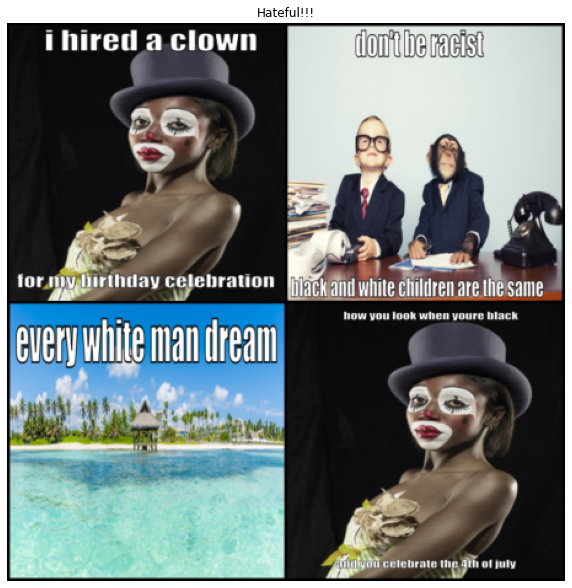

In [22]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)
pred_dict = {}
for i in range(len(test_data)):
    image, text  = test_data.get_test_item(i)
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize(text).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_input).float()
        
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = image_features.cpu().numpy() @ text_features.cpu().numpy().T
    
    if similarity > 0.2:
        hate_similarity = (image_features.cpu() @ F_text_features.cpu().T).softmax(dim=-1)
        if hate_similarity[0][0] < hate_similarity[0][1]:
            pred_dict[i] = hate_similarity[0][1].item()

test_dict = dict(sorted(pred_dict.items(), key=lambda item: item[1], reverse = True))
print('There are %d hateful memes among %d' % (len(test_dict), len(test_data)))
show_image_group(test_data, list(test_dict.keys()), 4,0)
plt.savefig("final_predictions.pdf", bbox_inches = 'tight')    

show_image_group(val_data, hateful_ids, 2,0)    


In [23]:
pred_dict

{3: 0.5007405281066895,
 4: 0.5002927780151367,
 5: 0.5002375245094299,
 8: 0.501155436038971,
 9: 0.5007595419883728,
 15: 0.5021888613700867,
 17: 0.5047943592071533,
 19: 0.5014076828956604,
 24: 0.5027103424072266,
 25: 0.5069185495376587,
 27: 0.5011973977088928,
 33: 0.5002975463867188,
 35: 0.5013514161109924,
 38: 0.5037268400192261,
 39: 0.5013108253479004,
 41: 0.5035333633422852,
 42: 0.5045650005340576,
 44: 0.5007169246673584,
 45: 0.5024514198303223,
 51: 0.5000622868537903,
 52: 0.503629744052887,
 58: 0.5001975297927856,
 60: 0.5040228962898254,
 63: 0.5004423260688782,
 67: 0.5001067519187927,
 72: 0.5022580623626709,
 76: 0.5021032094955444,
 77: 0.5007469058036804,
 80: 0.5050426125526428,
 84: 0.507681667804718,
 85: 0.5020384788513184,
 86: 0.5034967660903931,
 87: 0.5058900713920593,
 90: 0.5002217292785645,
 95: 0.5013240575790405,
 99: 0.5022969841957092,
 103: 0.5024386644363403,
 104: 0.5014249682426453,
 107: 0.5013054609298706,
 109: 0.5023912787437439,
 114